# Task 2, Made by Kyrylo Krocha

In [3]:
#!conda list freetype #freetype version should be 2.10.4, otherwise kernel can die
#!pip install -r "D:\\InterviewProject\\Task2\\requirements.TXT"

### Some imports

In [5]:
import rasterio
import cv2
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt

### Pathes to two images for matching

In [7]:
file_path = 'D:\\InterviewProject\\Task2\\dataset\\S2B_MSIL1C_20190830T083609_N0208_R064_T36UYA_20190830T114819\\S2B_MSIL1C_20190830T083609_N0208_R064_T36UYA_20190830T114819.SAFE\\GRANULE\\L1C_T36UYA_A012960_20190830T084008\\IMG_DATA\\T36UYA_20190830T083609_B05.jp2'
file_path2 = 'D:\\InterviewProject\\Task2\\dataset\\S2B_MSIL1C_20190830T083609_N0208_R064_T36UYA_20190830T114819\\S2B_MSIL1C_20190830T083609_N0208_R064_T36UYA_20190830T114819.SAFE\\GRANULE\\L1C_T36UYA_A012960_20190830T084008\\IMG_DATA\\T36UYA_20190830T083609_B08.jp2'

### Loading the satellite image

In [9]:
def load_image(image_path, max_dimension=1024):
    with rasterio.open(image_path, "r", driver='JP2OpenJPEG') as src:
        raster_image = src.read() 
        
    bands, height, width = raster_image.shape
    scale = max_dimension / max(height, width)
    new_height, new_width = int(height * scale), int(width * scale)
        
    resized_bands = [cv2.resize(raster_image[i], (new_width, new_height), interpolation=cv2.INTER_AREA) for i in range(bands)]
    resized_image = np.stack(resized_bands, axis=0).reshape(new_height, new_width, -1)
    return resized_image

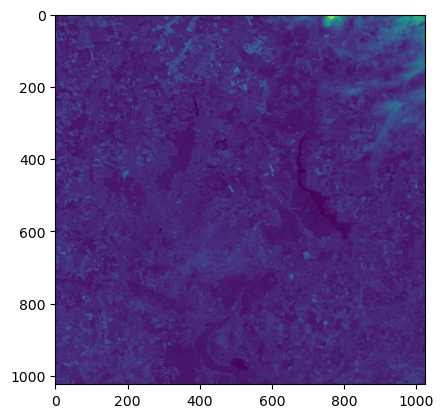

In [10]:
image = load_image(file_path)
plt.imshow(image)

#### same with other image

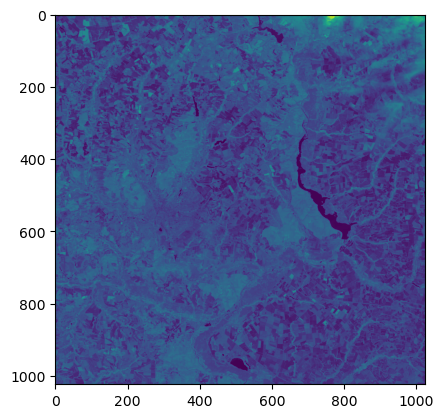

In [12]:
image2 = load_image(file_path2)
plt.imshow(image2)

### Saving images

In [14]:
cv2.imwrite("image.png", image)
cv2.imwrite("image2.png", image2)

True

### Reading them

In [16]:
img1 = cv2.imread("image.png", cv2.IMREAD_UNCHANGED)
img2 = cv2.imread("image2.png", cv2.IMREAD_UNCHANGED)

### Normalize images

In [18]:
def normalize_image(image):
    """
    Normalizes image values to [0, 255]
    """
    image = image.astype(np.float32)
    image = (image - image.min()) / (image.max() - image.min()) * 255.0  # Scale to 0-255
    return image.astype(np.uint8)

# Normalize the image
normalized_image = normalize_image(image)
normalized_image2 = normalize_image(image2)

### Convert to grayscale

In [20]:
img1 = normalize_image(img1)
img2 = normalize_image(img2)

if len(img1.shape) > 2:
    img1 = cv2.cvtColor(img1, cv2.COLOR_RGB2GRAY)
if len(img2.shape) > 2:
    img2 = cv2.cvtColor(img2, cv2.COLOR_RGB2GRAY)

### Match images

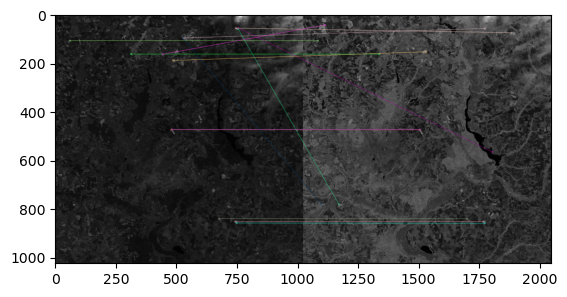

In [22]:
def match_images(img1, img2):
    """
    Matches keypoints between two images using ORB.
    """ 
    # ORB keypoint detection
    orb = cv2.ORB_create()
    keypoints1, descriptors1 = orb.detectAndCompute(img1, None)
    keypoints2, descriptors2 = orb.detectAndCompute(img2, None)

    # Match descriptors
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    matches = bf.match(descriptors1, descriptors2)
    matches = sorted(matches, key=lambda x: x.distance)

    return keypoints1, keypoints2, matches

# Example matching
keypoints1, keypoints2, matches = match_images(img1, img2)

# Visualize matches
match_image = cv2.drawMatches(img1, keypoints1, img2, keypoints2, matches[:20], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.imshow(match_image)
plt.show()